<img src="imgs/mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Worksheet S8: Location preprocessing

Con el auge de IoT y los dispositivos de seguimiento, uno de los tipos de datos más habituales son datos geolocalizados. Estos dispositivos pueden ser sensores estacionados en una localización concreta, dispositivos de seguimiento de entregas en vehículos, en pallets...

Con ello, surge la necesidad de no sólo realizar un tratamiento de los datos clave para agilizar los procesos, sino también, buena parte del tratamiento de los datos está centrado en la visualización. Por esto, en esta sesión haremos un trabajo conjunto entre visualización y preprocesamiento de los datos. Para esto último, trabajaremos con `folium`. Una librería pensada para generar gráficas de mapas que es importante tener en cuenta por su capacidad de mostrar miles de puntos al mismo tiempo, además de permitir interactividad.

Los datos están extraídos de __[OpenData Madrid](https://datos.madrid.es/portal/site/egob/)__, un repositorio de datos público con montones de datasets. Muy útil si lo que queremos es realizar algún análisis y empezar a ir construyendo nuestro portfolio de DataScientist.

**NOTA:** Actualmente Google Chrome tiene un problema al renderizar gráficos complejos con folium. Por eso **se recomienda encarecidamente** el realizar esta sesión con __[Mozilla Firefox](https://www.mozilla.org/es-ES/firefox/new/)__. Si nuestro navegador por defecto no es Firefox, podremos acceder al servidor de Jupyter Notebook una vez lo hayamos lanzado, copiando la url que contiene el token en el navegador Firefox.

<img src="imgs/notebookrun.png"/>

In [1]:
# instalar requisitos
import sys
!{sys.executable} -m pip install folium ortools --user

# Inicializamos entorno

In [2]:
import numpy as np
import pandas as pd
import re
import folium
import random

%matplotlib inline
import matplotlib.pyplot as plt 

random.seed(1234)
np.random.seed(seed=1234)

# Datos de sensores estáticos

Vamos a empezar a trabajar con los puestos de medida de la contaminación de Madrid. 

In [3]:
estaciones = pd.read_csv("data/madrid_estaciones_cont.csv")
estaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       0 non-null      float64
 1   NÚMERO           33 non-null     object 
 2   ESTACIÓN         35 non-null     object 
 3   DIRECCIÓN        35 non-null     object 
 4   LONGITUD         32 non-null     object 
 5   LATITUD          32 non-null     object 
 6   ALTITUD          32 non-null     float64
 7   TIPO ESTACION *  32 non-null     object 
 8   NO2              32 non-null     object 
 9   SO2              12 non-null     object 
 10  CO               14 non-null     object 
 11  PM10             15 non-null     object 
 12  PM2,5            7 non-null      object 
 13  O3               18 non-null     object 
 14  BTX              9 non-null      object 
 15  HC               4 non-null      object 
 16  UV               3 non-null      object 
 17  VV               7

In [4]:
estaciones.head()

,Unnamed: 0,NÚMERO,ESTACIÓN,DIRECCIÓN,LONGITUD,LATITUD,ALTITUD,TIPO ESTACION *,NO2,SO2,...,BTX,HC,UV,VV,DV,TMP,HR,PRB,RS,LL
0,NaN,4,Pza. de España,Plaza de España,"3º 42' 44,09''O","40º 25' 25,87''N",635.0,UT,X,X,...,NaN,NaN,NaN,X,X,X,X,NaN,NaN,X
1,NaN,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3º 40' 56,35''O","40º 25' 17,63''N",670.0,UT,X,X,...,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,"3º 40' 38,48''O","40º 27' 05,31''N",708.0,UT,X,NaN,...,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
3,NaN,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3º 38' 21,24''O","40º 26' 24,17''N",693.0,UF,X,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
4,NaN,17,Villaverde,C/. Juan Peñalver,"3º 42' 47,96''O","40º 20' 49,70''N",604.0,UF,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lo primero que observamos es que las columnas de localización `LONGITUD` y `LATITUD` están en un formato clásico de grados, minutos y segundos. Este no es el caso ideal, puesto que tanto `folium` como la mayoría de librerías trabajan con datos de longitud y latitud basadas en coordenadas partiendo del meridiano de Greenwich y ecuador. También podemos encontrarnos datos de tipo mercator, un sistema que se basa en dividir la esfera en sesenta particiones de 6 grados cada una.

Hay que tener en cuenta que en valores decimales de longitud y latitud, un decimal puede ser clave a la hora de establecer con precisión un punto. Todo depende también de nuestro hardware, pero con 6 decimales de precisión ya somos capaces de obtener un error de 16cm aproximadamente.

El primer paso, será pues, hacer la conversión a un tipo de coordenadas:

In [5]:
def convertir_coords(s):
    # https://pythex.org/
    import re
    if s is np.nan:
        return np.nan
    
    degrees, minutes, seconds, direction = re.split('[º \' "]+', s)
    seconds = seconds.replace(",", ".")
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','O'):
        dd*= -1
    
    return dd

**Expresiones regulares:** El código dentro de `re.split()` es una expresión regular, también llamada `regex`. Son muy utilizadas también en tratamiento del texto y consisten en un pseudolenguaje para realizar búsquedas. En general, son técnicas muy de _usar y tirar_, puesto que su comprensión a posteriori de haberlas utilizado, es compleja. Podéis practicar fácilmente en webs online como https://regex101.com/ teniendo en cuenta que exiten varios "sabores" del motor de regex, e intentando siempre buscar el sabor de Python, por ejemplo para este caso en concreto. Vamos a ver cómo funciona:

In [6]:
s = "3º 42' 44,09''O"
re.split('[º \' "]+', s)

['3', '42', '44,09', 'O']

Como vemos, ha realizado un split sobre el texto s basándose en los caracteres del regex que hemos especificado. Nuestra función `convertir_coords` realizará ese split y con una fórmula, calculará la transformación a latitud y longitud desde meridiano.

In [7]:
estaciones['Lon'] = estaciones['LONGITUD'].apply(convertir_coords)
estaciones['Lat'] = estaciones['LATITUD'].apply(convertir_coords)
estaciones[['ESTACIÓN', 'LATITUD', 'LONGITUD', 'Lat', 'Lon']].head()

,ESTACIÓN,LATITUD,LONGITUD,Lat,Lon
0,Pza. de España,"40º 25' 25,87''N","3º 42' 44,09''O",40.423853,-3.712247
1,Escuelas Aguirre,"40º 25' 17,63''N","3º 40' 56,35''O",40.421564,-3.682319
2,Avda. Ramón y Cajal,"40º 27' 05,31''N","3º 40' 38,48''O",40.451475,-3.677356
3,Arturo Soria,"40º 26' 24,17''N","3º 38' 21,24''O",40.440047,-3.639233
4,Villaverde,"40º 20' 49,70''N","3º 42' 47,96''O",40.347139,-3.713322


Antes de mostrar las estaciones, comprobamos que están todas tienen datos de geolocalización evitar complicarle la vida a folium:

In [8]:
estaciones[estaciones['Lat'].isna()]

,Unnamed: 0,NÚMERO,ESTACIÓN,DIRECCIÓN,LONGITUD,LATITUD,ALTITUD,TIPO ESTACION *,NO2,SO2,...,UV,VV,DV,TMP,HR,PRB,RS,LL,Lon,Lat
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,*,UT,Urbana de tráfico,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,UF,Urbana de fondo,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,S,Suburbana,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parece que en este caso no aportan información, así que nos las cargamos y posteriormente, generamos la gráfica con folium. Para centrar la gráfica en el mapa de madrid, vamos a calcular la media de todos los puntos.

In [9]:
estaciones = estaciones[~estaciones['Lat'].isna()]

In [10]:
#MADRID_COORDS = [40.4167,  -3.70325]
MADRID_COORDS = [estaciones['Lat'].mean(), estaciones['Lon'].mean()]

m = folium.Map(MADRID_COORDS, zoom_start=11)

for index, row in estaciones.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        folium.CircleMarker([row['Lat'], row['Lon']],
                            radius=2,
                            popup=row['NÚMERO'] +": "+ row['DIRECCIÓN'],
                            fill_color="#3db7e4",
                           ).add_to(m)
m

No estamos muy centrados en Madrid. Esto puede depender de varios motivos pero en este caso concreto podría ser porque existen puntos alejados de madrid. ¿Qué pasa si hacemos zoom out?

Efectivamente, encontraremos que hay estaciones muy alejadas y no precisamente en Madrid. Para detectar estos casos tan extremos, una de las formas más sencillas es utilizar un histograma.

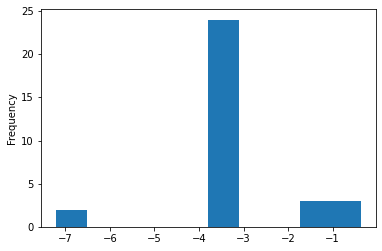

In [11]:
estaciones['Lon'].plot(kind = "hist")

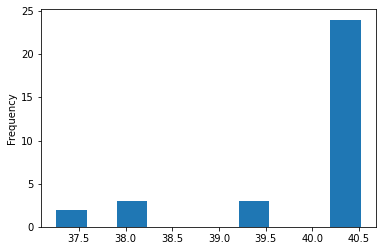

In [12]:
estaciones['Lat'].plot(kind = "hist")

Como podemos observar, la mayoría de puntos se condensan en una latitud y longitud que son las que nos interesan. Vamos a solucionar con un simple corte a los datos por el valor que más se asemeja a los puntos que están en Madrid.

In [13]:
estaciones = estaciones[estaciones['Lat'] > 40.]

Ahora sí, por fin tenemos nuestras estaciones de datos ya preprocesadas y listas para mostrar correctamente. Esta vez, además, vamos a mostrarlo en forma de heatmap, lo cual nos permitirá intuir dónde nuestras mediciones deberían resultar de más precisión con respecto a la condensación de sensores.

In [14]:
MADRID_COORDS = [40.4167,  -3.70325]
m = folium.Map(MADRID_COORDS, zoom_start=11)

for index, row in estaciones.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        folium.CircleMarker([row['Lat'], row['Lon']],
                            radius=2,
                            popup=row['DIRECCIÓN'],
                            fill_color="#3db7e4",
                           ).add_to(m)
        
# convertimos coordenadas a array de dos dimensiones
stationArr = estaciones[['Lat', 'Lon']].values

# ploteamos heatmap
from folium import plugins
m.add_child(plugins.HeatMap(stationArr, radius=25))
m

## Datos de seguimiento

Muchas veces nos interesa realizar un seguimiento, bien sea por tener sensores en movimiento o porque resulta interesante mostrar la evolución de los datos en un periodo de tiempo. En este caso, nuestros sensores no se moverán, pero vamos a preprocesar y mostrar los datos de contaminación de dióxido de carbono para el mes de Octubre de 2018 como una serie temporal en un heatmap.

Para ello recurrimos de nuevo a los datos de Open Data Madrid.

In [15]:
contamina = pd.read_csv('data/contamina_2018_10_diario.csv')
contamina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ESTACION  744 non-null    int64  
 1   MAGNITUD  744 non-null    int64  
 2   ANO       744 non-null    int64  
 3   MES       744 non-null    int64  
 4   DIA       744 non-null    int64  
 5   H08       744 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 35.0 KB


Damos un vistazo rápido a los datos.

In [16]:
contamina.head()

,ESTACION,MAGNITUD,ANO,MES,DIA,H08
0,4,7,2018,10,1,7.0
1,4,7,2018,10,2,54.0
2,4,7,2018,10,3,100.0
3,4,7,2018,10,4,124.0
4,4,7,2018,10,5,172.0


In [17]:
print("Máximo valor de contaminación: {}".format(max(contamina['H08'])))
print("Mínimo valor de contaminación: {}".format(min(contamina['H08'])))

Máximo valor de contaminación: 194.0
Mínimo valor de contaminación: 0.0


El primer paso será realizar cierto preprocesamiento. Primero para establecer un formato de fecha (aunque para folium no es estrictamente necesario) y luego para normalizar los datos de los sensores de la contaminación.

In [18]:
contamina['datestr'] = contamina['ANO'].astype(str) +"-"+ contamina['MES'].astype(str) +"-"+ contamina['DIA'].astype(str)
contamina['date'] = contamina.apply(lambda x: pd.to_datetime(x['datestr']), axis=1)
contamina.head()

,ESTACION,MAGNITUD,ANO,MES,DIA,H08,datestr,date
0,4,7,2018,10,1,7.0,2018-10-1,2018-10-01
1,4,7,2018,10,2,54.0,2018-10-2,2018-10-02
2,4,7,2018,10,3,100.0,2018-10-3,2018-10-03
3,4,7,2018,10,4,124.0,2018-10-4,2018-10-04
4,4,7,2018,10,5,172.0,2018-10-5,2018-10-05


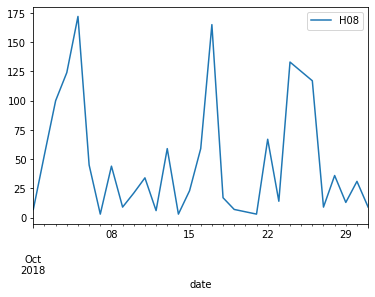

In [19]:
contamina[contamina['ESTACION'] == 4].sort_values(by = "date").plot(x = "date", y= "H08")

Normalizamos los valores de contaminación:

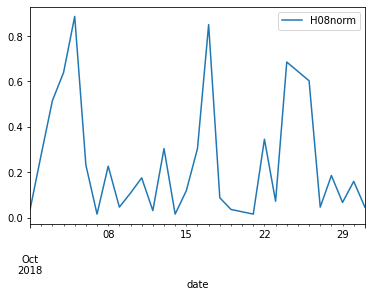

In [20]:
contamina['H08norm'] = contamina['H08'] / max(contamina['H08'])
contamina[contamina['ESTACION'] == 4].sort_values(by = "date").plot(x = "date", y= "H08norm")

Finalmente, mergeamos con las estaciones para tener un dataset listo antes de la gráfica.

In [21]:
estaciones['NÚMERO'] = estaciones['NÚMERO'].astype(int)
merged = estaciones.merge(contamina, how = "inner", left_on = "NÚMERO", right_on = "ESTACION")
merged = merged[["ESTACION", "DIRECCIÓN", "Lon", "Lat", "date", "datestr", "H08norm", "H08"]]
merged.head()

,ESTACION,DIRECCIÓN,Lon,Lat,date,datestr,H08norm,H08
0,4,Plaza de España,-3.712247,40.423853,2018-10-01,2018-10-1,0.036082,7.0
1,4,Plaza de España,-3.712247,40.423853,2018-10-02,2018-10-2,0.278351,54.0
2,4,Plaza de España,-3.712247,40.423853,2018-10-03,2018-10-3,0.515464,100.0
3,4,Plaza de España,-3.712247,40.423853,2018-10-04,2018-10-4,0.639175,124.0
4,4,Plaza de España,-3.712247,40.423853,2018-10-05,2018-10-5,0.886598,172.0


Finalmente, podemos mostrar la gráfica. Esta gráfica sólo será posible visualizarla correctamente en **Mozilla Firefox** por un problema de renderización en Google Chrome.

Para poder mostrar los datos, haremos uso de `HeatMapWithTime`. Esta función necesita de varios arrays anidados para mostrar los datos de tal forma que: 

* Cada fila es un periodo de tiempo (sea día, segundo, hora...)
* Cada fila dentro de esa fila representa información de un punto en concreto en ese instante en concreto.
* Los elementos dentro de esta última fila representan la información `[Lat, Lon, Weight]`. Donde Weight es el valor objetivo a mostrar en el heatmap.

In [22]:
days = merged['date'].unique()

heatmap_data = []
for d in days:
    day_data = [[row['Lat'], row['Lon'], row['H08norm']] for i, row in merged[merged['date'] == d].iterrows()]
    heatmap_data.append(day_data)
    
heatmap_data

[[[40.423852777777775, -3.7122472222222225, 0.03608247422680412],
  [40.42156388888888, -3.6823194444444445, 0.03608247422680412],
  [40.451475, -3.6773555555555553, 0.005154639175257732],
  [40.44004722222222, -3.6392333333333333, 0.020618556701030927],
  [40.34713888888889, -3.713322222222222, 0.005154639175257732],
  [40.394780555555556, -3.7318527777777777, 0.010309278350515464],
  [40.419355555555555, -3.7473472222222224, 0.005154639175257732],
  [40.47692777777778, -3.580030555555555, 0.020618556701030927],
  [40.41920833333333, -3.7031722222222223, 0.020618556701030927],
  [40.40794722222222, -3.6453055555555554, 0.010309278350515464],
  [40.445544444444444, -3.707127777777778, 0.06701030927835051],
  [40.47822777777778, -3.7115416666666667, 0.005154639175257732],
  [40.388152777777776, -3.6515222222222223, 0.005154639175257732],
  [40.398113888888886, -3.6868250000000002, 0.010309278350515464],
  [40.43989722222222, -3.690366666666667, 0.005154639175257732],
  [40.4144444444444

In [23]:
MADRID_COORDS = [40.4167,  -3.70325]
m = folium.Map(MADRID_COORDS, zoom_start=11)

for index, row in estaciones.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        folium.CircleMarker([row['Lat'], row['Lon']],
                            radius=2,
                            popup=row['DIRECCIÓN'],
                            fill_color="#3db7e4",
                           ).add_to(m)


hm = plugins.HeatMapWithTime(heatmap_data, radius = 60)
hm.add_to(m)
m

## Seguimiento de rutas

Otra de las posibilidades interesantes de IoT aplicada a geolocalización es el seguimiento de dispositivos. Uno de los formatos de más común en estos casos como estructura de la información es JSON, y en este caso se suele hablar de GeoJSON que viene en nuestro dataset dentro de la columna `track`, la cual nos indica todo el seguimiento de información de la ruta.

Trabajaremos pues con otro dataset de Madrid Open Data, que nos mostrará los datos de desplazamientos de bicicletas del servicio BiciMAD.

In [24]:
bicis = pd.read_json("data/bicimad_sept2018.json")
bicis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               1000 non-null   object
 1   ageRange          1000 non-null   int64 
 2   idplug_base       1000 non-null   int64 
 3   idplug_station    1000 non-null   int64 
 4   idunplug_base     1000 non-null   int64 
 5   idunplug_station  1000 non-null   int64 
 6   track             792 non-null    object
 7   travel_time       1000 non-null   int64 
 8   unplug_hourTime   1000 non-null   object
 9   user_day_code     1000 non-null   object
 10  user_type         1000 non-null   int64 
 11  zip_code          1000 non-null   object
dtypes: int64(7), object(5)
memory usage: 101.6+ KB


In [25]:
bicis.head()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,{'$oid': '5b9058462f38434ab0d85cd3'},0,5,16,17,40,"{'type': 'FeatureCollection', 'features': [{'g...",263,{'$date': '2018-09-01T01:00:00.000+0200'},ead1db07fa526e19fe237115d5516fbdc5acb99057b885...,1,
1,{'$oid': '5b9058462f38434ab0d85ce9'},2,12,52,26,85,"{'type': 'FeatureCollection', 'features': [{'g...",382,{'$date': '2018-09-01T01:00:00.000+0200'},420d9e220bd8816681162e15e9afcb1c69c5a756090728...,1,28009
2,{'$oid': '5b9058462f38434ab0d85ced'},4,1,58,11,109,"{'type': 'FeatureCollection', 'features': [{'g...",305,{'$date': '2018-09-01T01:00:00.000+0200'},780f5c8157efe8e6dca44dbd689817d4b126364fca917f...,1,28004
3,{'$oid': '5b9058462f38434ab0d85cee'},4,1,120,1,168,"{'type': 'FeatureCollection', 'features': [{'g...",262,{'$date': '2018-09-01T01:00:00.000+0200'},a225ab7b4b74954cd9fbe8cc2ec63390cd04e92cdd1a2f...,1,28015
4,{'$oid': '5b9058462f38434ab0d85cef'},4,19,80,8,89,"{'type': 'FeatureCollection', 'features': [{'g...",310,{'$date': '2018-09-01T01:00:00.000+0200'},867f38545733bc5f0c69d2592d228e01b3a39daa143e8b...,1,28007


Vamos a realizar el seguimiento de un usuario concreto. Esto viene indicado en la columna 'user_day_code'.

In [26]:
bicis['user_day_code'].value_counts()[:15]

6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf7464243ef6a1bf864a422    22
7d8e3a28f61f7d1ac179cccd02c632f276d4832c579de085c2e6efa560c83bfb    20
27081cb91508724d6f39675f0d3d89b47412a3188336f4e71b13bcaa9b03204f    19
f053b0598133ca7526ff0a4231609ab05a8e899fcdcd8371078e9207ba7ab63e    16
96dd55eb166cab0748a25465798d4a0d20259d4e4dc8fc7c619687a27bbf6fab    12
ad6572a307272e3975edf326749c133c3d32ed9c9fd8ce29f1084d4ca6c53ab7    12
01cc92b13dd2bdc6aee0159ff12b83965d783b557bec38347ae32ac9a71f2464    11
fc87f185d68c40120482f970b20a3ccccfbaf6f5cf7737a7438681155c0783bf     9
b74f1d77bb62c9224250c5cda50876ad502296cf19702ab42787ce877f00e18a     8
1abf9030698da7ff1e2d80087c1733fc2c5277339b345b7b6d0ad4eab564b02c     3
c1d8533c29722c41dcc3341c69494ff710af26ebe735d361704726af3b86a2e9     3
ec6657bcc4e503878a9b14853a492a54da66fee45e1cdd6f1434ced904edd724     2
d561370a123abdac783e04dab423fcf95ee3e525147f2f74f3de4afa1980c306     2
05e71d1d1ba35da3027118abca5281ed94b1578e005083dac555deb51120c16b     2
185c0f

In [27]:
user_day = bicis[bicis['user_day_code'] == '6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf7464243ef6a1bf864a422']
user_day.head()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
483,{'$oid': '5b90584a2f38434ab0d85f58'},5,23,130,21,142,"{'type': 'FeatureCollection', 'features': [{'g...",2744,{'$date': '2018-09-01T01:00:00.000+0200'},6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf746...,3,
487,{'$oid': '5b90584a2f38434ab0d85f5c'},5,22,130,18,142,"{'type': 'FeatureCollection', 'features': [{'g...",2833,{'$date': '2018-09-01T01:00:00.000+0200'},6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf746...,3,
493,{'$oid': '5b90584a2f38434ab0d85f63'},5,21,130,20,142,"{'type': 'FeatureCollection', 'features': [{'g...",2876,{'$date': '2018-09-01T01:00:00.000+0200'},6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf746...,3,
496,{'$oid': '5b90584a2f38434ab0d85f67'},5,20,130,22,142,"{'type': 'FeatureCollection', 'features': [{'g...",2965,{'$date': '2018-09-01T01:00:00.000+0200'},6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf746...,3,
501,{'$oid': '5b90584a2f38434ab0d85f71'},5,17,130,24,142,"{'type': 'FeatureCollection', 'features': [{'g...",3060,{'$date': '2018-09-01T01:00:00.000+0200'},6b73fba7594b52f910338d9c6a4c9b208128bf3a6cf746...,3,


Escogeremos uno de los trayectos mostrados del dataset.

In [28]:
user_day['track'].iloc[0]
df_track = pd.DataFrame(user_day['track'].iloc[0]['features'])
df_track

,geometry,type,properties
0,"{'type': 'Point', 'coordinates': [-3.691513099...",Feature,"{'var': '28004,ES,Madrid,Madrid,CALLE GENOVA 2..."
1,"{'type': 'Point', 'coordinates': [-3.6896865, ...",Feature,"{'var': '28046,ES,Madrid,Madrid,PASEO CASTELLA..."
2,"{'type': 'Point', 'coordinates': [-3.6891208, ...",Feature,"{'var': '28046,ES,Madrid,Madrid,PASEO CASTELLA..."
3,"{'type': 'Point', 'coordinates': [-3.691815499...",Feature,"{'var': '28046,ES,Madrid,Madrid,PASEO CASTELLA..."
4,"{'type': 'Point', 'coordinates': [-3.692057799...",Feature,"{'var': '28003,ES,Madrid,Madrid,CALLE RAIMUNDO..."
5,"{'type': 'Point', 'coordinates': [-3.6950725, ...",Feature,"{'var': '28020,ES,Madrid,Madrid,CALLE AGUSTIN ..."
6,"{'type': 'Point', 'coordinates': [-3.697459799...",Feature,"{'var': '28003,ES,Madrid,Madrid,CALLE RAIMUNDO..."
7,"{'type': 'Point', 'coordinates': [-3.703918599...",Feature,"{'var': '28020,ES,Madrid,Madrid,GTA CUATRO CAM..."
8,"{'type': 'Point', 'coordinates': [-3.703558799...",Feature,"{'var': '28020,ES,Madrid,Madrid,CALLE BRAVO MU..."
9,"{'type': 'Point', 'coordinates': [-3.702895799...",Feature,"{'var': '28020,ES,Madrid,Madrid,CALLE JUAN DE ..."


Ahora vamos a convertir la información de coordenadas del trayecto a un formato entendible por folium:

In [29]:
coords = []
timestamps = []

for i, rowtrack in df_track.iterrows():
    coords.append(rowtrack['geometry']['coordinates'][::-1]) # establecemos lon, lat como pares de coordenadas
    timestamps.append(rowtrack['properties']['secondsfromstart'])

print("Coordenadas: {}".format(coords))
print("Segundos desde inicio: {}".format(timestamps))

Coordenadas: [[40.4255972997, -3.6915130997], [40.4282164997, -3.6896865], [40.4355181, -3.6891208], [40.4425098, -3.6918154999999997], [40.4462623, -3.6920577999999997], [40.4467320997, -3.6950725], [40.4467399997, -3.6974597997], [40.4473067997, -3.7039185999999997], [40.4493305, -3.7035587999999997], [40.4534795, -3.7028957997000003], [40.4551913, -3.7025617996999998], [40.4574934997, -3.7014139999999998], [40.4574568, -3.7010879997], [40.4572307997, -3.7003297997], [40.4557339997, -3.6985906]]
Segundos desde inicio: [1635, 1575, 1515, 1455, 1395, 1336, 1276, 1216, 1156, 1096, 1036, 977, 378, 319, 259]


In [30]:
MADRID_COORDS = [40.4425, -3.6950]
m = folium.Map(MADRID_COORDS, zoom_start=14)

for i, e in enumerate(coords):
    folium.CircleMarker([e[0], e[1]],
                    radius=2,
                    fill_color="#3db7e4",
                    popup="s: {}".format(timestamps[i]),
                   ).add_to(m)

folium.PolyLine(coords).add_to(m)
folium.Marker(coords[0]).add_to(m)

m

Folium también es compatible con GeoJSON. Hemos visto la estructura del camino recorrido por la bicicleta definida como puntos y esto es fácilmente reproducible si aplicamos una capa de GeoJSON con folium.

In [31]:
bicis['track'][12]

{'type': 'FeatureCollection',
 'features': [{'geometry': {'type': 'Point',
    'coordinates': [-3.6729520997, 40.4198584997]},
   'type': 'Feature',
   'properties': {'var': '28009,ES,Madrid,Madrid,CALLE MAIQUEZ 28,Madrid',
    'speed': 5.55,
    'secondsfromstart': 173}},
  {'geometry': {'type': 'Point', 'coordinates': [-3.6718628, 40.4181716]},
   'type': 'Feature',
   'properties': {'var': '28009,ES,Madrid,Madrid,CALLE IBIZA,Madrid',
    'speed': 5.58,
    'secondsfromstart': 113}},
  {'geometry': {'type': 'Point', 'coordinates': [-3.6697128, 40.4181571]},
   'type': 'Feature',
   'properties': {'var': '28009,ES,Madrid,Madrid,CALLE IBIZA,Madrid',
    'speed': 3.77,
    'secondsfromstart': 52}}]}

In [32]:
folium.GeoJson(
    bicis['track'][485],
    name='geojson',
    
).add_to(m)

In [33]:
m

Sin embargo, como puedes ver, aquí sólo estamos mostrando puntos concretos. Esto es porque la definición de nuestros datos vienen definidos como tal. Para que se mostrase el camino, deberían estar definidos como una línea y no como puntos dispersos. Un ejemplo de esto se puede encontrar en: https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/antarctic_ice_edge.json

## Cálculo de rutas optimas (TSP - Traveling Salesman Problem)

Uno de los problemas más comunes pero más complicado de resolver consiste en el problema del Traveling Salesman Problem. Básicamente, consiste en calcular la ruta óptima entre un conjunto de puntos con respecto al objetivo de minimizar la distancia recorrida. Estos problemas, crecen en complejidad exponencialmente con cada punto nuevo que se añade al dataset y por lo tanto encontrar una solución mediante fuerza bruta suele ser tan costoso que queda descartado.

Las técnicas habituales para solventar estos problemas consisten en heurísticas, que no nos aseguran una solución óptima pero sí una solución "aceptable" y permiten reducir por mucho el coste computacional del problema.

Lamentablemente Google Maps API ya no permite el cálculo de distancias entre dos puntos de forma gratuita. Sin embargo, existe la distancia `haversine`, o distancia a vuelo de pájaro, que se puede calcular con la siguiente fórmula:

$$a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)$$
$$c = 2 * asin(sqrt(a))$$
$$haversine dist = c * r$$

In [34]:
def haversine(lon1, lat1, lon2, lat2):
    from math import radians, cos, sin, asin, sqrt
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radio de la tierra en km.
    
    return c * r

In [35]:
madrid = [40.5249725, -4.3764475]
valencia = [39.4078969, -0.431551]
sevilla = [38.8888962,-6.1653639]

print("Haversine Madrid-Valencia: {:.2f}".format(haversine(madrid[1], madrid[0], valencia[1], valencia[0])))
print("Haversine Madrid-Sevilla: {:.2f}".format(haversine(madrid[1], madrid[0], sevilla[1], sevilla[0])))

Haversine Madrid-Valencia: 358.36
Haversine Madrid-Sevilla: 237.72


Según Google maps, la distancia en ruta entre Madrid y Valencia es de 358km, pero eso es sólo porque en este caso, es un trayecto por carretera en prácticamente linea recta. En Madrid - Sevilla, donde Haversine nos calcula 237km vemos que Google maps nos ofrece una ruta óptima de 537km.

Para optimizar rutas, Google ofrece la librería OR-Tools para problemas de optimización de rutas. Es una librería muy completa donde los problemas son altamente configurables, pero nosotros nos centraremos en un problema básico con las ciudades anteriores. Para ello, necesitamos: 
* Obtener nuestra matriz de distancias, que contendrá la distancia punto a punto para todas las combinaciones posibles.
* Definir las dimensiones del problema. En nuestro caso será la distancia recorrida, pero en realidad puede que nos encontremos una dimensión a optimizar la como carga del vehículo.

OR-Tools ofrece muchas funciones, configuraciones y optimizadores con diferentes heurísticas. Como este es un problema tan complejo, no nos centraremos estudiar a fondo las posibilidades, sino en mostrar un ejemplo. Para evitar los detalles de implementación, os hemos preparado el módulo ```optimizer.py``` que contiene todas las funciones necesarias. Siempre sois libres de dar un vistazo y leer más sobre or-Tools en la documentación oficial:

https://developers.google.com/optimization/introduction/overview

In [36]:
from optimizer import HaversineRouteOptimizer

madrid = [40.5249725, -4.3764475]
valencia = [39.4078969, -0.431551]
sevilla = [38.8888962, -6.1653639]
granada = [37.1810095, -3.6262912]
pamplona = [42.8157961, -1.6675312]

locations = [madrid, valencia, sevilla, granada, pamplona]
names = ["madrid", "valencia", "sevilla", "granada", "pamplona"]

Una vez tenemos el problema modelado, instanciamos nuestro optimizador ```HaversineRouteOptimizer``` para posteriormente llamar a la función ```optimize``` y ejecutar el optimizador.

In [37]:
hdo = HaversineRouteOptimizer()
routes = hdo.optimize(locations, names, origin = 0, n_vehicles=2)

Computing distance matrix...
Creating data model...
Results: 
Vehicle: 0   Distance:  906km   Route: ['madrid', 'granada', 'sevilla', 'madrid']
Vehicle: 1   Distance: 1089km   Route: ['madrid', 'valencia', 'pamplona', 'madrid']
Total distance: 1995km


In [38]:
routes

[{'id': 0, 'steps': [0, 3, 2, 0], 'distance': 906},
 {'id': 1, 'steps': [0, 1, 4, 0], 'distance': 1089}]

***

## Conclusiones

* ¿Qué otras ideas se te ocurren para trabajar con datos de Open Data Madrid geolocalizados?
* ¿Crees que el problema TSP es sencillo o complejo de resolver?
* ¿Qué aproximación podríamos tomar si tuviesemos que realizar el mayor número de tareas en el mínimo de tiempo posible?